In [1]:
import pandas as pd
import numpy as np
import json
import warnings
import spacy
warnings.filterwarnings("ignore")
import random
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer

import re

from spacy.tokens import DocBin

from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [2]:
train_data = pd.read_csv(r"C:\Users\sai\Desktop\PRAXIS\Term - 3\CAPP\Datasets\train.csv")
features = pd.read_csv(r"C:\Users\sai\Desktop\PRAXIS\Term - 3\CAPP\Datasets\features.csv")
patient_notes = pd.read_csv(r"C:\Users\sai\Desktop\PRAXIS\Term - 3\CAPP\Datasets\patient_notes.csv")

### CASE - 3

In [3]:
case_3_features = features[features["case_num"] == 3]
case_3_features

,feature_num,case_num,feature_text
43,300,3,FHx-of-PUD-OR-Family-history-of-peptic-ulcer-d...
44,301,3,Epigastric-discomfort
45,302,3,Darker-bowel-movements
46,303,3,NSAID-use-OR-Nonsteroidal-anti-inflammatory-dr...
47,304,3,burning-OR-gnawing-OR-burning-and-gnawing
48,305,3,Post-prandial-bloating-OR-fullness-with-meals
49,306,3,getting-worse-OR-progressive-OR-symptoms-now-d...
50,307,3,2-to-3-beers-a-week
51,308,3,Male
52,309,3,duration-2-months


In [4]:
case_3_pn = patient_notes[patient_notes["case_num"] ==  3]
case_3_pn

,pn_num,case_num,pn_history
5034,30000,3,"35 YO M WAITH MIDEPIGARTRIC PAIN, NO RADIATIO..."
5035,30001,3,"Chief Complaint: 35 yo M presenting with ""stom..."
5036,30002,3,35 y/o male with 20 year smoking history who p...
5037,30003,3,Pt is 35 y/o male comes in c/o central abdomin...
5038,30004,3,35 yo M with epigastric pain for the past 2 mo...
...,...,...,...
14782,39931,3,35 yo m presenting with stomach troubles inter...
14783,39932,3,35 YO M C/O STOMACH PAIN X 2 MONTHS. \r\nPAIN ...
14784,39933,3,"ID/CC: 35M with ""stomach problems""\r\nHPI: Int..."
14785,39934,3,"35 year old male presents to the clinic for ""s..."


In [5]:
case_3_train = train_data[train_data["case_num"] == 3]
case_3_train = case_3_train[case_3_train.annotation != '[]']
case_3_train.head()

,id,case_num,pn_num,feature_num,annotation,location
4300,30037_300,3,30037,300,['Uncle with bleeding ulcer'],['844 869']
4301,30037_301,3,30037,301,['pain is located in the epigastric region'],['124 164']
4302,30037_302,3,30037,302,['stools have appeared darker'],['508 535']
4303,30037_303,3,30037,303,['Motrin'],['771 777']
4304,30037_304,3,30037,304,['burning/gnawing'],['206 221']


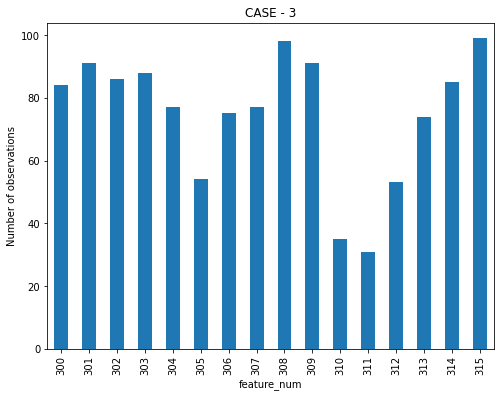

In [6]:
plt.figure(figsize=[8,6])
case_3_train.groupby("feature_num").size().plot.bar()
plt.title("CASE - 3")
plt.ylabel("Number of observations")
plt.show()

### Over Sampling for CASE 3

In [7]:
pn_dict = {}
for idx, row in case_3_pn.iterrows():
    pn_dict[row['pn_num']] = row['pn_history']

In [8]:
new_annotation = []
for case_id in case_3_features['case_num'].unique():
    
    all_pn_id = set(case_3_pn[case_3_pn['case_num']==case_id]['pn_num'].tolist())
    
    for feature_id in case_3_features[case_3_features['case_num']==case_id]['feature_num'].unique():
        # get all the pn_num that have already been annotated
        annotated_pn = set(case_3_train[case_3_train['feature_num']==feature_id]['pn_num'].tolist())
        # get all the pn_num that have NOT been annotated
        pn_to_annotate = all_pn_id-annotated_pn
        
        # get all current annotations
        # we will use them to find more annotations
        annotations = case_3_train[case_3_train['feature_num']==feature_id]['annotation'].tolist()
        annotation_texts = set()
        for a in annotations:
            anns = eval(a)
            for at in anns:
                annotation_texts.add(at)
                
        # annotate       
        for pn_id in pn_to_annotate:
            new_annotation_pn, new_location_pn = [], []
            pn_text = pn_dict[pn_id]
            for at in annotation_texts:
                start = pn_text.find(at)
                if start>=0:
                    new_annotation_pn.append(at)
                    new_location_pn.append(f'{start} {start+len(at)}')
            if len(new_annotation_pn)>0:
                new_annotation.append((
                    f'{pn_id:04d}_{feature_id:03d}',
                    case_id,
                    pn_id,
                    feature_id,
                    new_annotation_pn,
                    new_location_pn
                ))
     #   break
    break
    # break to get sample results quickly

In [9]:
len(new_annotation)

83864

In [10]:
df=pd.DataFrame(new_annotation)
df.head()

,0,1,2,3,4,5
0,32770_300,3,32770,300,[Uncle with bleeding ulcer],[540 565]
1,32772_300,3,32772,300,[Uncle with bleeding ulcer],[662 687]
2,32773_300,3,32773,300,[uncle with bleeding ulcer],[606 631]
3,32779_300,3,32779,300,[paternal uncle had bleeding ulcer],[669 702]
4,32780_300,3,32780,300,[uncle with bleeding ulcer],[919 944]


In [11]:
df.columns=['id','case_num','pn_num','feature_num','annotation','location']
df.head()

,id,case_num,pn_num,feature_num,annotation,location
0,32770_300,3,32770,300,[Uncle with bleeding ulcer],[540 565]
1,32772_300,3,32772,300,[Uncle with bleeding ulcer],[662 687]
2,32773_300,3,32773,300,[uncle with bleeding ulcer],[606 631]
3,32779_300,3,32779,300,[paternal uncle had bleeding ulcer],[669 702]
4,32780_300,3,32780,300,[uncle with bleeding ulcer],[919 944]


In [12]:
df["location"] = df["location"].apply(str)
df["annotation"] = df["annotation"].apply(str)

df["annotation"] = df.annotation.str.replace('[','')
df["annotation"] = df.annotation.str.replace(']','')
df["location"] = df.location.str.replace('[','')
df["location"] = df.location.str.replace(']','')

df.head()

,id,case_num,pn_num,feature_num,annotation,location
0,32770_300,3,32770,300,'Uncle with bleeding ulcer','540 565'
1,32772_300,3,32772,300,'Uncle with bleeding ulcer','662 687'
2,32773_300,3,32773,300,'uncle with bleeding ulcer','606 631'
3,32779_300,3,32779,300,'paternal uncle had bleeding ulcer','669 702'
4,32780_300,3,32780,300,'uncle with bleeding ulcer','919 944'


In [13]:
# 313, 312, 311, 310, 307, 305 

In [14]:
df_305 = df[(df["feature_num"] == 305)][['pn_num','annotation',"location","feature_num"]].sample(n = 50, random_state = 100)
df_305.shape

(50, 4)

In [15]:
df_305 = (df_305.set_index(['pn_num',"feature_num"]) 
   .apply(lambda col: col.str.split(',').explode())
   .reset_index()
   .reindex(df_305.columns, axis=1))
df_305

,pn_num,annotation,location,feature_num
0,38182,'BLOATING','191 199',305
1,37786,'bloating','482 490',305
2,31700,'bloating','338 346',305
3,35729,'bloating','414 422',305
4,35725,'bloated','435 442',305
...,...,...,...,...
57,34569,'bloating','347 355',305
58,34569,'bloating after eating','347 368',305
59,33752,'bloating','315 323',305
60,30040,'bloating','166 174',305


In [16]:
df_305["start_location"] = df_305["location"].apply(lambda x: x.split()[0][1:])
df_305["end_location"] = df_305["location"].apply(lambda x: x.split()[-1][:-1])
df_305

,pn_num,annotation,location,feature_num,start_location,end_location
0,38182,'BLOATING','191 199',305,191,199
1,37786,'bloating','482 490',305,482,490
2,31700,'bloating','338 346',305,338,346
3,35729,'bloating','414 422',305,414,422
4,35725,'bloated','435 442',305,435,442
...,...,...,...,...,...,...
57,34569,'bloating','347 355',305,347,355
58,34569,'bloating after eating','347 368',305,347,368
59,33752,'bloating','315 323',305,315,323
60,30040,'bloating','166 174',305,166,174


In [17]:
df_307 = df[(df["feature_num"] == 307)][['pn_num','annotation',"location","feature_num"]].sample(n = 40, random_state = 100)
df_307.shape

(40, 4)

In [18]:
df_307 = (df_307.set_index(['pn_num',"feature_num"]) 
   .apply(lambda col: col.str.split(',').explode())
   .reset_index()
   .reindex(df_307.columns, axis=1))
df_307.head()

,pn_num,annotation,location,feature_num
0,34508,'2 drinks per week','596 613',307
1,37792,'few beers a week','925 941',307
2,32610,'1-2 beers per week','672 690',307
3,31966,'occasional alcohol','607 625',307
4,37446,'few beers/wk','741 753',307


In [19]:
df_307["start_location"] = df_307["location"].apply(lambda x: x.split()[0][1:])
df_307["end_location"] = df_307["location"].apply(lambda x: x.split()[-1][:-1])
df_307.head()

,pn_num,annotation,location,feature_num,start_location,end_location
0,34508,'2 drinks per week','596 613',307,596,613
1,37792,'few beers a week','925 941',307,925,941
2,32610,'1-2 beers per week','672 690',307,672,690
3,31966,'occasional alcohol','607 625',307,607,625
4,37446,'few beers/wk','741 753',307,741,753


In [20]:
df_310 = df[(df["feature_num"] == 310)][['pn_num','annotation',"location","feature_num"]].sample(n =70, random_state = 100)
df_310.shape

(70, 4)

In [21]:
df_310 = (df_310.set_index(['pn_num',"feature_num"]) 
   .apply(lambda col: col.str.split(',').explode())
   .reset_index()
   .reindex(df_310.columns, axis=1))
df_310

,pn_num,annotation,location,feature_num
0,30691,'pain wakes him up at night','323 349',310
1,30691,'wakes him up at night','328 349',310
2,35768,'pain wakes him up at night','295 321',310
3,35768,'wakes him up at night','300 321',310
4,34748,'woken him up from sleep','137 160',310
...,...,...,...,...
83,37579,'pain wakes him up at night','255 281',310
84,37579,'wakes him up at night','260 281',310
85,39171,'wakes him up at night','454 475',310
86,30105,'sometimes at night','144 162',310


In [22]:
df_310["start_location"] = df_310["location"].apply(lambda x: x.split()[0][1:])
df_310["end_location"] = df_310["location"].apply(lambda x: x.split()[-1][:-1])
df_310.head()

,pn_num,annotation,location,feature_num,start_location,end_location
0,30691,'pain wakes him up at night','323 349',310,323,349
1,30691,'wakes him up at night','328 349',310,328,349
2,35768,'pain wakes him up at night','295 321',310,295,321
3,35768,'wakes him up at night','300 321',310,300,321
4,34748,'woken him up from sleep','137 160',310,137,160


In [23]:
df_311 = df[(df["feature_num"] == 311)][['pn_num','annotation',"location","feature_num"]].sample(n =75, random_state = 100)
df_311.shape

(75, 4)

In [24]:
df_311 = (df_311.set_index(['pn_num',"feature_num"]) 
   .apply(lambda col: col.str.split(',').explode())
   .reset_index()
   .reindex(df_311.columns, axis=1))
df_311

,pn_num,annotation,location,feature_num
0,30082,'no gross blood','508 522',311
1,39172,'no bright red blood','578 597',311
2,38403,'no frank blood','836 850',311
3,34970,'no blood','537 545',311
4,34405,'No blood in stool','255 272',311
...,...,...,...,...
78,37580,'no blood','235 243',311
79,37403,'no frank blood','205 219',311
80,37403,'no blood','259 267',311
81,37403,'no frank blood in stool','205 228',311


In [25]:
df_311["start_location"] = df_311["location"].apply(lambda x: x.split()[0][1:])
df_311["end_location"] = df_311["location"].apply(lambda x: x.split()[-1][:-1])
df_311.head()

,pn_num,annotation,location,feature_num,start_location,end_location
0,30082,'no gross blood','508 522',311,508,522
1,39172,'no bright red blood','578 597',311,578,597
2,38403,'no frank blood','836 850',311,836,850
3,34970,'no blood','537 545',311,537,545
4,34405,'No blood in stool','255 272',311,255,272


In [26]:
df_312 = df[(df["feature_num"] == 312)][['pn_num','annotation',"location","feature_num"]].sample(n =60, random_state = 100)
df_312.shape

(60, 4)

In [27]:
df_312 = (df_312.set_index(['pn_num',"feature_num"]) 
   .apply(lambda col: col.str.split(',').explode())
   .reset_index()
   .reindex(df_312.columns, axis=1))
df_312

,pn_num,annotation,location,feature_num
0,34958,'intermittent','522 534',312
1,30662,'comes and goes','258 272',312
2,30662,'comes and go','258 270',312
3,37368,'intermittent','87 99',312
4,36711,'comes and goes','57 71',312
...,...,...,...,...
84,38420,'comes and goes','270 284',312
85,38420,'comes and go','270 282',312
86,33500,'intermittent','28 40',312
87,39220,'comes and goes','157 171',312


In [28]:
df_312["start_location"] = df_312["location"].apply(lambda x: x.split()[0][1:])
df_312["end_location"] = df_312["location"].apply(lambda x: x.split()[-1][:-1])
df_312.head()

,pn_num,annotation,location,feature_num,start_location,end_location
0,34958,'intermittent','522 534',312,522,534
1,30662,'comes and goes','258 272',312,258,272
2,30662,'comes and go','258 270',312,258,270
3,37368,'intermittent','87 99',312,87,99
4,36711,'comes and goes','57 71',312,57,71


In [29]:
df_313 = df[(df["feature_num"] == 313)][['pn_num','annotation',"location","feature_num"]].sample(n =40, random_state = 100)
df_313.shape

(40, 4)

In [30]:
df_313 = (df_313.set_index(['pn_num',"feature_num"]) 
   .apply(lambda col: col.str.split(',').explode())
   .reset_index()
   .reindex(df_313.columns, axis=1))
df_313.head()

,pn_num,annotation,location,feature_num
0,31440,'Tums helped at first','367 387',313
1,38515,'tums no longer help','290 309',313
2,32621,'tums used to help','337 354',313
3,36293,'tums used to help','136 153',313
4,33287,'Tums initially helped','156 177',313


In [31]:
df_313["start_location"] = df_313["location"].apply(lambda x: x.split()[0][1:])
df_313["end_location"] = df_313["location"].apply(lambda x: x.split()[-1][:-1])
df_313.head()

,pn_num,annotation,location,feature_num,start_location,end_location
0,31440,'Tums helped at first','367 387',313,367,387
1,38515,'tums no longer help','290 309',313,290,309
2,32621,'tums used to help','337 354',313,337,354
3,36293,'tums used to help','136 153',313,136,153
4,33287,'Tums initially helped','156 177',313,156,177


### CASE - 3 Train Data

In [32]:
case_3_train = case_3_train[['pn_num','annotation',"location","feature_num"]]

In [33]:
case_3_train.loc[4384 ,"annotation"] = "['gnawing burning']" 
case_3_train.loc[4752 ,"annotation"] = "['gnawing burning']" 
case_3_train.loc[4832  ,"annotation"] = "['burning gnawing']" 
case_3_train.loc[5040   ,"annotation"] = "['nagging burning']" 
case_3_train.loc[5168   ,"annotation"] = "['burning knawing']" 
case_3_train.loc[5200   ,"annotation"] = "['buring gnawing']" 
case_3_train.loc[5296   ,"annotation"] = "['burning gnawing']" 
case_3_train.loc[5472  ,"annotation"] = "['burning nawing']" 
case_3_train.loc[5808    ,"annotation"] = "['burning gnawing']" 
case_3_train.loc[5888    ,"annotation"] = "['gnawing and burning']"
case_3_train.loc[4338,"annotation"] = 'initially had 1 episode of this pain per week but now it occurs twice per day'
case_3_train.loc[4386,"annotation"] = "['worsening', 'Had it once a week  but not 2-3 times a week']"
case_3_train.loc[5193 ,"annotation"] = 'TUMS  which initially helped'
case_3_train.loc[4809 ,"annotation"] = 'used to be relieved w/ Tums  now it does not'
case_3_train.loc[4473 ,"annotation"] = 'Toms helped relieve pain at beginning  but no longer helps'
case_3_train.loc[4489  ,"annotation"] = 'alleviated with Tums at first  but nor anymore'
case_3_train.loc[4777   ,"annotation"] = 'Tums used to alleviate the pain  but not anymore'
case_3_train.loc[4793   ,"annotation"] = 'tums  now less effective'
case_3_train.loc[5289   ,"annotation"] = 'tums used to alleivate the pain  no longer does'
case_3_train.loc[5337   ,"annotation"] = 'tried tums which helps relieve the pain  but recently it has not worked'
case_3_train.loc[5369    ,"annotation"] = 'TUMS  but no longer effective'
case_3_train.loc[5401     ,"annotation"] = 'Tums used to make it better  but no longer works'
case_3_train.loc[5481     ,"annotation"] = 'tums for relief  but now they dont help much'
case_3_train.loc[5721     ,"annotation"] = 'PARTIALLY ALLEV BY ANTACIDS  NOT ANYLONGER'
case_3_train.loc[5865     ,"annotation"] = 'TUMS help for a little while  but has stopped'
case_3_train.loc[5881     ,"annotation"] = 'Previously had relief with TUMS  now pain does not go away'
case_3_train.loc[5545  ,"annotation"] = "['TUMS  which initially helped', 'TUMS not as useful']"

In [34]:
case_3_train["annotation"] = case_3_train.annotation.str.replace('[','')
case_3_train["annotation"] = case_3_train.annotation.str.replace(']','')
case_3_train["location"] = case_3_train.location.str.replace('[','')
case_3_train["location"] = case_3_train.location.str.replace(']','')

case_3_train

,pn_num,annotation,location,feature_num
4300,30037,'Uncle with bleeding ulcer','844 869',300
4301,30037,'pain is located in the epigastric region','124 164',301
4302,30037,'stools have appeared darker','508 535',302
4303,30037,'Motrin','771 777',303
4304,30037,'burning/gnawing','206 221',304
...,...,...,...,...
5893,39921,'began 2 months ago','94 112',309
5894,39921,'pain waking him from sleep','260 286',310
5897,39921,'Not alleviated by antacids anymore','383 417',313
5898,39921,'nausea','251 257',314


In [35]:
case_3_train = (case_3_train.set_index(['pn_num',"feature_num"]) 
   .apply(lambda col: col.str.split(',').explode())
   .reset_index()
   .reindex(case_3_train.columns, axis=1))
case_3_train

,pn_num,annotation,location,feature_num
0,30037,'Uncle with bleeding ulcer','844 869',300
1,30037,'pain is located in the epigastric region','124 164',301
2,30037,'stools have appeared darker','508 535',302
3,30037,'Motrin','771 777',303
4,30037,'burning/gnawing','206 221',304
...,...,...,...,...
1318,39921,'began 2 months ago','94 112',309
1319,39921,'pain waking him from sleep','260 286',310
1320,39921,'Not alleviated by antacids anymore','383 417',313
1321,39921,'nausea','251 257',314


In [36]:
case_3_train["start_location"] = case_3_train["location"].apply(lambda x: x.split()[0][1:])
case_3_train["end_location"] = case_3_train["location"].apply(lambda x: x.split()[-1][:-1])
case_3_train

,pn_num,annotation,location,feature_num,start_location,end_location
0,30037,'Uncle with bleeding ulcer','844 869',300,844,869
1,30037,'pain is located in the epigastric region','124 164',301,124,164
2,30037,'stools have appeared darker','508 535',302,508,535
3,30037,'Motrin','771 777',303,771,777
4,30037,'burning/gnawing','206 221',304,206,221
...,...,...,...,...,...,...
1318,39921,'began 2 months ago','94 112',309,94,112
1319,39921,'pain waking him from sleep','260 286',310,260,286
1320,39921,'Not alleviated by antacids anymore','383 417',313,383,417
1321,39921,'nausea','251 257',314,251,257


In [37]:
case_3 = pd.concat([case_3_train, df_305, df_307, df_310,df_311, df_312, df_313])
case_3.shape

(1729, 6)

In [38]:
case_3 = case_3.merge(patient_notes, on='pn_num', how='left')
case_3

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history
0,30037,'Uncle with bleeding ulcer','844 869',300,844,869,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...
1,30037,'pain is located in the epigastric region','124 164',301,124,164,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...
2,30037,'stools have appeared darker','508 535',302,508,535,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...
3,30037,'Motrin','771 777',303,771,777,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...
4,30037,'burning/gnawing','206 221',304,206,221,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...
...,...,...,...,...,...,...,...,...
1724,37965,'tums used to help','332 349',313,332,349,3,patient is a 35 yo M here for abdominal pain s...
1725,37260,'Tums helped at first','151 171',313,151,171,3,35 yo male with stomahc problems. For 2 months...
1726,38883,'Tums helped at first','205 225',313,205,225,3,35 yo M patient complains of stomach problems....
1727,35290,'Tums initially helped','275 296',313,275,296,3,Chad Hamilton is a 35 year old man who present...


In [39]:
case_3["New_annotation"] = case_3.apply(lambda x: x.pn_history[int(x.start_location):int(x.end_location)],axis=1)
case_3.head()

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation
0,30037,'Uncle with bleeding ulcer','844 869',300,844,869,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,Uncle with bleeding ulcer
1,30037,'pain is located in the epigastric region','124 164',301,124,164,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,pain is located in the epigastric region
2,30037,'stools have appeared darker','508 535',302,508,535,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,stools have appeared darker
3,30037,'Motrin','771 777',303,771,777,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,Motrin
4,30037,'burning/gnawing','206 221',304,206,221,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,burning/gnawing


In [40]:
case_3["New_annotation"] = case_3["New_annotation"].apply(lambda x: re.sub(r'''[/"+,()\r\n]''',' ',x))
case_3["New_annotation"] = case_3["New_annotation"].apply(lambda x: re.sub(r'''[']''','',x))
case_3["New_annotation"] = case_3["New_annotation"].apply(lambda x: x.strip())
case_3

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation
0,30037,'Uncle with bleeding ulcer','844 869',300,844,869,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,Uncle with bleeding ulcer
1,30037,'pain is located in the epigastric region','124 164',301,124,164,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,pain is located in the epigastric region
2,30037,'stools have appeared darker','508 535',302,508,535,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,stools have appeared darker
3,30037,'Motrin','771 777',303,771,777,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,Motrin
4,30037,'burning/gnawing','206 221',304,206,221,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,burning gnawing
...,...,...,...,...,...,...,...,...,...
1724,37965,'tums used to help','332 349',313,332,349,3,patient is a 35 yo M here for abdominal pain s...,tums used to help
1725,37260,'Tums helped at first','151 171',313,151,171,3,35 yo male with stomahc problems. For 2 months...,Tums helped at first
1726,38883,'Tums helped at first','205 225',313,205,225,3,35 yo M patient complains of stomach problems....,Tums helped at first
1727,35290,'Tums initially helped','275 296',313,275,296,3,Chad Hamilton is a 35 year old man who present...,Tums initially helped


In [41]:
case_3["New_pn_history"] = case_3["pn_history"].apply(lambda x: re.sub(r'''[/",+()\r\n]''',' ',x))
case_3["New_pn_history"] = case_3["New_pn_history"].apply(lambda x: re.sub(r'''[']''','',x))
case_3

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history
0,30037,'Uncle with bleeding ulcer','844 869',300,844,869,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,Uncle with bleeding ulcer,CC: Stomach pain HPI: Patient is a 35 year...
1,30037,'pain is located in the epigastric region','124 164',301,124,164,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,pain is located in the epigastric region,CC: Stomach pain HPI: Patient is a 35 year...
2,30037,'stools have appeared darker','508 535',302,508,535,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,stools have appeared darker,CC: Stomach pain HPI: Patient is a 35 year...
3,30037,'Motrin','771 777',303,771,777,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,Motrin,CC: Stomach pain HPI: Patient is a 35 year...
4,30037,'burning/gnawing','206 221',304,206,221,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,burning gnawing,CC: Stomach pain HPI: Patient is a 35 year...
...,...,...,...,...,...,...,...,...,...,...
1724,37965,'tums used to help','332 349',313,332,349,3,patient is a 35 yo M here for abdominal pain s...,tums used to help,patient is a 35 yo M here for abdominal pain s...
1725,37260,'Tums helped at first','151 171',313,151,171,3,35 yo male with stomahc problems. For 2 months...,Tums helped at first,35 yo male with stomahc problems. For 2 months...
1726,38883,'Tums helped at first','205 225',313,205,225,3,35 yo M patient complains of stomach problems....,Tums helped at first,35 yo M patient complains of stomach problems....
1727,35290,'Tums initially helped','275 296',313,275,296,3,Chad Hamilton is a 35 year old man who present...,Tums initially helped,Chad Hamilton is a 35 year old man who present...


In [42]:
def word_lemm(sentence):
    word_list = nltk.word_tokenize(sentence)
    
    lemmaztier = WordNetLemmatizer()
    lemmatized_output = ' '.join([lemmaztier.lemmatize(w) for w in word_list])
    return(lemmatized_output)

In [43]:
case_3["New_annotation"] = case_3["New_annotation"].apply(word_lemm)
case_3["New_pn_history"] = case_3["New_pn_history"].apply(word_lemm)
case_3.head()

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history
0,30037,'Uncle with bleeding ulcer','844 869',300,844,869,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,Uncle with bleeding ulcer,CC : Stomach pain HPI : Patient is a 35 year o...
1,30037,'pain is located in the epigastric region','124 164',301,124,164,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,pain is located in the epigastric region,CC : Stomach pain HPI : Patient is a 35 year o...
2,30037,'stools have appeared darker','508 535',302,508,535,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,stool have appeared darker,CC : Stomach pain HPI : Patient is a 35 year o...
3,30037,'Motrin','771 777',303,771,777,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,Motrin,CC : Stomach pain HPI : Patient is a 35 year o...
4,30037,'burning/gnawing','206 221',304,206,221,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,burning gnawing,CC : Stomach pain HPI : Patient is a 35 year o...


In [44]:
case_3["new_location"] = case_3.apply(lambda x :re.search(r'\b' + x.New_annotation + r'\b', x.New_pn_history),axis =1)
case_3

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history,new_location
0,30037,'Uncle with bleeding ulcer','844 869',300,844,869,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,Uncle with bleeding ulcer,CC : Stomach pain HPI : Patient is a 35 year o...,"<re.Match object; span=(834, 859), match='Uncl..."
1,30037,'pain is located in the epigastric region','124 164',301,124,164,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,pain is located in the epigastric region,CC : Stomach pain HPI : Patient is a 35 year o...,"<re.Match object; span=(123, 163), match='pain..."
2,30037,'stools have appeared darker','508 535',302,508,535,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,stool have appeared darker,CC : Stomach pain HPI : Patient is a 35 year o...,"<re.Match object; span=(502, 528), match='stoo..."
3,30037,'Motrin','771 777',303,771,777,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,Motrin,CC : Stomach pain HPI : Patient is a 35 year o...,"<re.Match object; span=(762, 768), match='Motr..."
4,30037,'burning/gnawing','206 221',304,206,221,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,burning gnawing,CC : Stomach pain HPI : Patient is a 35 year o...,"<re.Match object; span=(202, 217), match='burn..."
...,...,...,...,...,...,...,...,...,...,...,...
1724,37965,'tums used to help','332 349',313,332,349,3,patient is a 35 yo M here for abdominal pain s...,tum used to help,patient is a 35 yo M here for abdominal pain s...,"<re.Match object; span=(334, 350), match='tum ..."
1725,37260,'Tums helped at first','151 171',313,151,171,3,35 yo male with stomahc problems. For 2 months...,Tums helped at first,35 yo male with stomahc problem . For 2 month ...,"<re.Match object; span=(149, 169), match='Tums..."
1726,38883,'Tums helped at first','205 225',313,205,225,3,35 yo M patient complains of stomach problems....,Tums helped at first,35 yo M patient complains of stomach problem ....,"<re.Match object; span=(199, 219), match='Tums..."
1727,35290,'Tums initially helped','275 296',313,275,296,3,Chad Hamilton is a 35 year old man who present...,Tums initially helped,Chad Hamilton is a 35 year old man who present...,"<re.Match object; span=(263, 284), match='Tums..."


In [45]:
drop_index = []
for  index,row in case_3.iterrows():
    if row["new_location"] == None:
        drop_index.append(index)
        
print(drop_index),len(drop_index)

[94, 102, 112, 194, 223, 277, 283, 326, 394, 400, 404, 408, 413, 417, 455, 461, 481, 516, 526, 542, 548, 722, 738, 761, 765, 901, 903, 1025, 1278, 1535, 1627, 1629, 1647, 1672, 1690, 1698, 1723]


(None, 37)

In [46]:
case_3 = case_3.drop(drop_index,axis = 0)
case_3

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history,new_location
0,30037,'Uncle with bleeding ulcer','844 869',300,844,869,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,Uncle with bleeding ulcer,CC : Stomach pain HPI : Patient is a 35 year o...,"<re.Match object; span=(834, 859), match='Uncl..."
1,30037,'pain is located in the epigastric region','124 164',301,124,164,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,pain is located in the epigastric region,CC : Stomach pain HPI : Patient is a 35 year o...,"<re.Match object; span=(123, 163), match='pain..."
2,30037,'stools have appeared darker','508 535',302,508,535,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,stool have appeared darker,CC : Stomach pain HPI : Patient is a 35 year o...,"<re.Match object; span=(502, 528), match='stoo..."
3,30037,'Motrin','771 777',303,771,777,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,Motrin,CC : Stomach pain HPI : Patient is a 35 year o...,"<re.Match object; span=(762, 768), match='Motr..."
4,30037,'burning/gnawing','206 221',304,206,221,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,burning gnawing,CC : Stomach pain HPI : Patient is a 35 year o...,"<re.Match object; span=(202, 217), match='burn..."
...,...,...,...,...,...,...,...,...,...,...,...
1724,37965,'tums used to help','332 349',313,332,349,3,patient is a 35 yo M here for abdominal pain s...,tum used to help,patient is a 35 yo M here for abdominal pain s...,"<re.Match object; span=(334, 350), match='tum ..."
1725,37260,'Tums helped at first','151 171',313,151,171,3,35 yo male with stomahc problems. For 2 months...,Tums helped at first,35 yo male with stomahc problem . For 2 month ...,"<re.Match object; span=(149, 169), match='Tums..."
1726,38883,'Tums helped at first','205 225',313,205,225,3,35 yo M patient complains of stomach problems....,Tums helped at first,35 yo M patient complains of stomach problem ....,"<re.Match object; span=(199, 219), match='Tums..."
1727,35290,'Tums initially helped','275 296',313,275,296,3,Chad Hamilton is a 35 year old man who present...,Tums initially helped,Chad Hamilton is a 35 year old man who present...,"<re.Match object; span=(263, 284), match='Tums..."


In [47]:
case_3["start_location"] = case_3.apply(lambda x :re.search(r'\b' + x.New_annotation + r'\b', x.New_pn_history).start(),axis =1)
case_3["end_location"] = case_3.apply(lambda x :re.search(r'\b' + x.New_annotation + r'\b', x.New_pn_history).end(),axis =1)
case_3

,pn_num,annotation,location,feature_num,start_location,end_location,case_num,pn_history,New_annotation,New_pn_history,new_location
0,30037,'Uncle with bleeding ulcer','844 869',300,834,859,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,Uncle with bleeding ulcer,CC : Stomach pain HPI : Patient is a 35 year o...,"<re.Match object; span=(834, 859), match='Uncl..."
1,30037,'pain is located in the epigastric region','124 164',301,123,163,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,pain is located in the epigastric region,CC : Stomach pain HPI : Patient is a 35 year o...,"<re.Match object; span=(123, 163), match='pain..."
2,30037,'stools have appeared darker','508 535',302,502,528,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,stool have appeared darker,CC : Stomach pain HPI : Patient is a 35 year o...,"<re.Match object; span=(502, 528), match='stoo..."
3,30037,'Motrin','771 777',303,762,768,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,Motrin,CC : Stomach pain HPI : Patient is a 35 year o...,"<re.Match object; span=(762, 768), match='Motr..."
4,30037,'burning/gnawing','206 221',304,202,217,3,CC: Stomach pain \r\n\r\nHPI: Patient is a 35 ...,burning gnawing,CC : Stomach pain HPI : Patient is a 35 year o...,"<re.Match object; span=(202, 217), match='burn..."
...,...,...,...,...,...,...,...,...,...,...,...
1724,37965,'tums used to help','332 349',313,334,350,3,patient is a 35 yo M here for abdominal pain s...,tum used to help,patient is a 35 yo M here for abdominal pain s...,"<re.Match object; span=(334, 350), match='tum ..."
1725,37260,'Tums helped at first','151 171',313,149,169,3,35 yo male with stomahc problems. For 2 months...,Tums helped at first,35 yo male with stomahc problem . For 2 month ...,"<re.Match object; span=(149, 169), match='Tums..."
1726,38883,'Tums helped at first','205 225',313,199,219,3,35 yo M patient complains of stomach problems....,Tums helped at first,35 yo M patient complains of stomach problem ....,"<re.Match object; span=(199, 219), match='Tums..."
1727,35290,'Tums initially helped','275 296',313,263,284,3,Chad Hamilton is a 35 year old man who present...,Tums initially helped,Chad Hamilton is a 35 year old man who present...,"<re.Match object; span=(263, 284), match='Tums..."


### Feature 300

In [48]:
case_3 = case_3.drop(index = 1199, axis = 0)

In [49]:
case_3_300 = case_3[case_3["feature_num"] == 300]
case_3_300.shape

(85, 11)

In [50]:
pn_Num_list = list(case_3_300.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_3_300[case_3_300.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_3_300[case_3_300.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
    
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_300.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_300.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(66, 17)

In [51]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_300.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 264.07it/s]


In [52]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_300.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 363.01it/s]


In [53]:
!python -m spacy init fill-config ./base_config_300.cfg ./config_300.cfg

[+] Auto-filled config with all values
[+] Saved config
config_300.cfg
You can now add your data and train your pipeline:
python -m spacy train config_300.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-06 15:15:28.621620: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 15:15:28.621679: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [54]:
!python -m spacy train config_300.cfg --output ./output_300

[i] Saving to output directory: output_300
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     66.83    0.00    0.00    0.00    0.00
  3     200        390.23   1607.34   91.43   88.89   94.12    0.91
  6     400         26.28     30.44   82.35   82.35   82.35    0.82
  9     600         12.16     12.36   91.43   88.89   94.12    0.91
 12     800          4.97      6.05   91.43   88.89   94.12    0.91
 15    1000          0.65      0.96   91.43   88.89   94.12    0.91
 18    1200          3.56      3.02   88.89   84.21   94.12    0.89
 21    1400          0.89      0.46   85.71   83.33   88.24    0.86
 24    1600      

2022-05-06 15:15:41.345633: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 15:15:41.345710: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-06 15:15:47,453] [INFO] Set up nlp object from config
[2022-05-06 15:15:47,484] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-06 15:15:47,496] [INFO] Created vocabulary
[2022-05-06 15:15:47,501] [INFO] Finished initializing nlp object
[2022-05-06 15:15:48,878] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 301

In [55]:
case_3 = case_3.drop(index = 91, axis = 0)

In [56]:
case_3_301 = case_3[case_3["feature_num"] == 301]
case_3_301.shape

(96, 11)

In [57]:
pn_Num_list = list(case_3_301.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_3_301[case_3_301.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_3_301[case_3_301.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
    
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_301.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_301.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(72, 19)

In [58]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_301.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 459.55it/s]


In [59]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_301.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 754.16it/s]


In [60]:
!python -m spacy init fill-config ./base_config_301.cfg ./config_301.cfg

[+] Auto-filled config with all values
[+] Saved config
config_301.cfg
You can now add your data and train your pipeline:
python -m spacy train config_301.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-06 15:20:44.108893: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 15:20:44.108933: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [61]:
!python -m spacy train config_301.cfg --output ./output_301

[i] Saving to output directory: output_301
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     48.50    0.00    0.00    0.00    0.00
  2     200       6776.88   1728.28   64.86   70.59   60.00    0.65
  5     400       3660.81    268.28   57.89   61.11   55.00    0.58
  8     600         70.37     95.60   46.15   47.37   45.00    0.46
 11     800         73.42     52.95   70.27   76.47   65.00    0.70
 13    1000         40.60     25.00   66.67   75.00   60.00    0.67
 16    1200         16.13      8.73   61.11   68.75   55.00    0.61
 19    1400         14.83      6.06   59.46   64.71   55.00    0.59
 23    1600      

2022-05-06 15:20:50.763458: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 15:20:50.763594: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-06 15:20:53,797] [INFO] Set up nlp object from config
[2022-05-06 15:20:53,805] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-06 15:20:53,809] [INFO] Created vocabulary
[2022-05-06 15:20:53,810] [INFO] Finished initializing nlp object
[2022-05-06 15:20:54,248] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 302

In [62]:
case_3 = case_3.drop(index = 520, axis = 0)

In [63]:
case_3_302 = case_3[case_3["feature_num"] == 302]
case_3_302.shape

(88, 11)

In [64]:
pn_Num_list = list(case_3_302.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_3_302[case_3_302.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_3_302[case_3_302.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
    
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_302.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_302.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(68, 18)

In [65]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_302.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 551.13it/s]


In [66]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_302.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 950.07it/s]


In [67]:
!python -m spacy init fill-config ./base_config_302.cfg ./config_302.cfg

[+] Auto-filled config with all values
[+] Saved config
config_302.cfg
You can now add your data and train your pipeline:
python -m spacy train config_302.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-06 15:27:16.560096: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 15:27:16.560136: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [68]:
!python -m spacy train config_302.cfg --output ./output_302

[i] Saving to output directory: output_302
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     53.50    0.00    0.00    0.00    0.00
  2     200       5487.39   1987.59   65.00   61.90   68.42    0.65
  5     400         21.54     50.98   66.67   65.00   68.42    0.67
  8     600          2.48      3.56   75.68   77.78   73.68    0.76
 11     800          0.00      0.00   71.79   70.00   73.68    0.72
 14    1000          0.00      0.00   71.79   70.00   73.68    0.72
 17    1200          0.00      0.00   71.79   70.00   73.68    0.72
 21    1400          0.00      0.00   73.68   73.68   73.68    0.74
 25    1600      

2022-05-06 15:27:22.388454: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 15:27:22.388499: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-06 15:27:26,256] [INFO] Set up nlp object from config
[2022-05-06 15:27:26,266] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-06 15:27:26,270] [INFO] Created vocabulary
[2022-05-06 15:27:26,271] [INFO] Finished initializing nlp object
[2022-05-06 15:27:26,824] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 303

In [69]:
case_3 = case_3.drop(index = 843, axis = 0)
case_3 = case_3.drop(index = 935, axis = 0)
case_3 = case_3.drop(index = 477, axis = 0)
case_3 = case_3.drop(index = 960, axis = 0)
case_3 = case_3.drop(index = 250, axis = 0)
case_3 = case_3.drop(index = 949, axis = 0)
case_3 = case_3.drop(index = 745, axis = 0)
case_3 = case_3.drop(index = 1037, axis = 0)
case_3 = case_3.drop(index = 784, axis = 0)
case_3 = case_3.drop(index = 1174, axis = 0)
case_3 = case_3.drop(index = 1009, axis = 0)
case_3 = case_3.drop(index = 860, axis = 0)
case_3 = case_3.drop(index = 620, axis = 0)
case_3 = case_3.drop(index = 436, axis = 0)
case_3 = case_3.drop(index = 490, axis = 0)

In [70]:
case_3_303 = case_3[case_3["feature_num"] == 303]
case_3_303.shape

(98, 11)

In [71]:
pn_Num_list = list(case_3_303.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_3_303[case_3_303.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_3_303[case_3_303.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
    
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_303.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_303.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(70, 18)

In [72]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_303.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 253.17it/s]


In [73]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_303.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 440.50it/s]


In [74]:
!python -m spacy init fill-config ./base_config_303.cfg ./config_303.cfg

[+] Auto-filled config with all values

2022-05-06 15:32:10.868202: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 15:32:10.868251: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



[+] Saved config
config_303.cfg
You can now add your data and train your pipeline:
python -m spacy train config_303.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [75]:
!python -m spacy train config_303.cfg --output ./output_303

[i] Saving to output directory: output_303
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     60.17    0.00    0.00    0.00    0.00
  2     200         24.25   1109.39   70.00   66.67   73.68    0.70
  5     400         41.00     72.55   48.48   57.14   42.11    0.48
  8     600         31.15     44.22   66.67   60.87   73.68    0.67
 11     800         32.09     23.82   57.89   57.89   57.89    0.58
 14    1000         26.71     23.43   63.41   59.09   68.42    0.63
 17    1200         21.25     19.42   61.11   64.71   57.89    0.61
 20    1400         35.58     24.34   64.86   66.67   63.16    0.65
 24    1600      

2022-05-06 15:32:22.503870: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 15:32:22.504007: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-06 15:32:30,324] [INFO] Set up nlp object from config
[2022-05-06 15:32:30,334] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-06 15:32:30,337] [INFO] Created vocabulary
[2022-05-06 15:32:30,338] [INFO] Finished initializing nlp object
[2022-05-06 15:32:30,854] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 304

In [76]:
case_3 = case_3.drop(index = 874, axis = 0)

In [77]:
case_3_304 = case_3[case_3["feature_num"] == 304]
case_3_304.shape

(79, 11)

In [78]:
pn_Num_list = list(case_3_304.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_3_304[case_3_304.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_3_304[case_3_304.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
    
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_304.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_304.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(61, 16)

In [79]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_304.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 545.34it/s]

Skipping entity


In [80]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_304.spacy")

100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1004.49it/s]


In [81]:
!python -m spacy init fill-config ./base_config_304.cfg ./config_304.cfg

[+] Auto-filled config with all values
[+] Saved config
config_304.cfg
You can now add your data and train your pipeline:
python -m spacy train config_304.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-06 15:38:50.557024: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 15:38:50.557201: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [82]:
!python -m spacy train config_304.cfg --output ./output_304

[i] Saving to output directory: output_304
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     60.83    0.00    0.00    0.00    0.00
  3     200       6217.52   1345.55   87.50   93.33   82.35    0.87
  6     400      13268.75    411.37   84.85   87.50   82.35    0.85
  9     600          3.95      5.30   87.50   93.33   82.35    0.87
 13     800          0.00      0.00   87.50   93.33   82.35    0.87
 16    1000          0.00      0.00   87.50   93.33   82.35    0.87
 19    1200          0.00      0.00   87.50   93.33   82.35    0.87
 23    1400          0.00      0.00   87.50   93.33   82.35    0.87
 28    1600      

2022-05-06 15:38:56.969193: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 15:38:56.969254: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-06 15:39:01,441] [INFO] Set up nlp object from config
[2022-05-06 15:39:01,450] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-06 15:39:01,453] [INFO] Created vocabulary
[2022-05-06 15:39:01,454] [INFO] Finished initializing nlp object
[2022-05-06 15:39:01,895] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 305

In [83]:
case_3 = case_3.drop(index = 82, axis = 0)

case_3 = case_3.drop(index = 1219, axis = 0)

case_3 = case_3.drop(index = 236, axis = 0)

case_3 = case_3.drop(index = 1315, axis = 0)

case_3 = case_3.drop(index = 109, axis = 0)

In [84]:
case_3 = case_3.drop(index = 1356, axis = 0)

In [85]:
case_3 = case_3.drop(index = 1380, axis = 0)

In [86]:
case_3 = case_3.drop(index = 1373, axis = 0)

In [87]:
case_3 = case_3.drop(index = 1344, axis = 0)

In [88]:
case_3 = case_3.drop(index = 1378, axis = 0)

In [89]:
case_3 = case_3.drop(index = 1336, axis = 0)

In [90]:
case_3 = case_3.drop(index = 1335, axis = 0)

In [91]:
case_3 = case_3.drop(index = 1341, axis = 0)

In [92]:
case_3 = case_3.drop(index = 1366, axis = 0)

In [93]:
case_3 = case_3.drop(index = 1331, axis = 0)

In [94]:
case_3_305 = case_3[case_3["feature_num"] == 305]
case_3_305.shape

(110, 11)

In [95]:
pn_Num_list = list(case_3_305.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_3_305[case_3_305.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_3_305[case_3_305.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
    
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_305.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_305.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(83, 21)

In [96]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_305.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 391.01it/s]


In [97]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_305.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 554.51it/s]


In [98]:
!python -m spacy init fill-config ./base_config_305.cfg ./config_305.cfg

[+] Auto-filled config with all values
[+] Saved config
config_305.cfg
You can now add your data and train your pipeline:
python -m spacy train config_305.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-06 15:41:42.914590: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 15:41:42.914657: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [99]:
!python -m spacy train config_305.cfg --output ./output_305

[i] Saving to output directory: output_305
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     67.67    0.00    0.00    0.00    0.00
  2     200         30.68   1242.25   42.11   50.00   36.36    0.42
  4     400       1268.52    351.95   70.27   86.67   59.09    0.70
  7     600         44.86     88.83   80.00   88.89   72.73    0.80
  9     800       1417.43     99.72   75.68   93.33   63.64    0.76
 12    1000         41.40     31.82   83.72   85.71   81.82    0.84
 14    1200          4.42      2.21   75.00   83.33   68.18    0.75
 16    1400         18.86      8.52   61.54   70.59   54.55    0.62
 19    1600      

2022-05-06 15:41:51.358659: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 15:41:51.358697: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-06 15:41:55,355] [INFO] Set up nlp object from config
[2022-05-06 15:41:55,367] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-06 15:41:55,374] [INFO] Created vocabulary
[2022-05-06 15:41:55,376] [INFO] Finished initializing nlp object
[2022-05-06 15:41:55,903] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 306

In [100]:
case_3 = case_3.drop(index = 877, axis = 0)

In [101]:
case_3_306 = case_3[case_3["feature_num"] == 306]
case_3_306.shape

(105, 11)

In [102]:
pn_Num_list = list(case_3_306.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_3_306[case_3_306.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_3_306[case_3_306.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
    
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_306.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_306.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(60, 15)

In [103]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_306.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 590.20it/s]


In [104]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_306.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 519.03it/s]


In [105]:
!python -m spacy init fill-config ./base_config_306.cfg ./config_306.cfg

[+] Auto-filled config with all values
[+] Saved config
config_306.cfg
You can now add your data and train your pipeline:
python -m spacy train config_306.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-06 15:46:00.559061: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 15:46:00.559112: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [106]:
!python -m spacy train config_306.cfg --output ./output_306

[i] Saving to output directory: output_306
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     51.00    4.26    3.85    4.76    0.04
  3     200         35.70   1356.44   43.75   63.64   33.33    0.44
  6     400       2741.28    238.76   63.16   70.59   57.14    0.63
 10     600         38.04     41.17   45.00   47.37   42.86    0.45
 13     800         50.34     27.92   54.05   62.50   47.62    0.54
 16    1000         17.58     13.50   70.00   73.68   66.67    0.70
 20    1200          7.47      3.57   64.86   75.00   57.14    0.65
 23    1400         41.54     13.71   50.00   52.63   47.62    0.50
 28    1600      

2022-05-06 15:46:07.194653: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 15:46:07.194738: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-06 15:46:10,899] [INFO] Set up nlp object from config
[2022-05-06 15:46:10,909] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-06 15:46:10,912] [INFO] Created vocabulary
[2022-05-06 15:46:10,913] [INFO] Finished initializing nlp object
[2022-05-06 15:46:11,393] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 307

In [107]:
case_3 = case_3.drop(index = 1422, axis = 0)

In [108]:
case_3 = case_3.drop(index = 1396, axis = 0)

In [109]:
case_3 = case_3.drop(index = 1414, axis = 0)

In [110]:
case_3 = case_3.drop(index = 1407, axis = 0)

In [111]:
case_3_307 = case_3[case_3["feature_num"] == 307]
case_3_307.shape

(116, 11)

In [112]:
pn_Num_list = list(case_3_307.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_3_307[case_3_307.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_3_307[case_3_307.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
    
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_307.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_307.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(92, 24)

In [113]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_307.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 92/92 [00:00<00:00, 782.10it/s]


In [114]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_307.spacy")

100%|████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 1094.55it/s]


In [115]:
!python -m spacy init fill-config ./base_config_307.cfg ./config_307.cfg

[+] Auto-filled config with all values
[+] Saved config
config_307.cfg
You can now add your data and train your pipeline:
python -m spacy train config_307.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-06 15:49:53.430171: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 15:49:53.430209: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [116]:
!python -m spacy train config_307.cfg --output ./output_307

[i] Saving to output directory: output_307
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     47.33    1.41    0.85    4.17    0.01
  2     200        183.03   1466.90   50.91   45.16   58.33    0.51
  4     400        105.00    161.96   56.00   53.85   58.33    0.56
  6     600         80.59     94.22   48.15   43.33   54.17    0.48
  8     800         89.55     73.79   60.47   68.42   54.17    0.60
 10    1000         70.51     55.18   53.66   64.71   45.83    0.54
 13    1200         29.81     22.83   51.06   52.17   50.00    0.51
 15    1400         12.03      6.82   68.09   69.57   66.67    0.68
 18    1600      

2022-05-06 15:49:58.291651: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 15:49:58.291687: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-06 15:50:01,267] [INFO] Set up nlp object from config
[2022-05-06 15:50:01,276] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-06 15:50:01,280] [INFO] Created vocabulary
[2022-05-06 15:50:01,281] [INFO] Finished initializing nlp object
[2022-05-06 15:50:01,774] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 308

In [117]:
case_3_308 = case_3[case_3["feature_num"] == 308]
case_3_308.shape

(100, 11)

In [118]:
pn_Num_list = list(case_3_308.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_3_308[case_3_308.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_3_308[case_3_308.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
    
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_308.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_308.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(73, 19)

In [119]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_308.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 73/73 [00:00<00:00, 903.65it/s]

Skipping entity
Skipping entity


In [120]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_308.spacy")

100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 1046.57it/s]

Skipping entity


In [121]:
!python -m spacy init fill-config ./base_config_308.cfg ./config_308.cfg

[+] Auto-filled config with all values
[+] Saved config
config_308.cfg
You can now add your data and train your pipeline:
python -m spacy train config_308.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-06 16:02:32.393127: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 16:02:32.393163: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [122]:
!python -m spacy train config_308.cfg --output ./output_308

[i] Saving to output directory: output_308
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     52.50    0.00    0.00    0.00    0.00
  2     200          6.22   1007.81   97.56   95.24  100.00    0.98
  5     400          1.81      2.00   95.24   90.91  100.00    0.95
  8     600          0.00      0.00   95.24   90.91  100.00    0.95
 10     800          0.00      0.00   95.24   90.91  100.00    0.95
 13    1000          0.00      0.00   95.24   90.91  100.00    0.95
 16    1200          0.00      0.00   95.24   90.91  100.00    0.95
 19    1400          0.00      0.00   95.24   90.91  100.00    0.95
 23    1600      

2022-05-06 16:02:37.208226: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 16:02:37.208266: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-06 16:02:40,100] [INFO] Set up nlp object from config
[2022-05-06 16:02:40,107] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-06 16:02:40,110] [INFO] Created vocabulary
[2022-05-06 16:02:40,110] [INFO] Finished initializing nlp object
[2022-05-06 16:02:40,459] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 309

In [123]:
case_3 = case_3.drop(index = 60, axis = 0)
case_3 = case_3.drop(index = 589, axis = 0)

In [124]:
case_3_309 = case_3[case_3["feature_num"] == 309]
case_3_309.shape

(94, 11)

In [125]:
pn_Num_list = list(case_3_309.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_3_309[case_3_309.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_3_309[case_3_309.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
    
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_309.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_309.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(72, 18)

In [126]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_309.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 628.18it/s]


In [127]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_309.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 752.46it/s]


In [128]:
!python -m spacy init fill-config ./base_config_309.cfg ./config_309.cfg

[+] Auto-filled config with all values
[+] Saved config
config_309.cfg
You can now add your data and train your pipeline:
python -m spacy train config_309.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-06 16:04:36.207758: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 16:04:36.207809: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [129]:
!python -m spacy train config_309.cfg --output ./output_309

[i] Saving to output directory: output_309
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     52.50    0.00    0.00    0.00    0.00
  2     200       1751.03   2167.85   73.68   77.78   70.00    0.74
  5     400         32.47     92.01   54.55   50.00   60.00    0.55
  8     600         14.42     29.03   52.38   50.00   55.00    0.52
 11     800         27.11     24.06   55.00   55.00   55.00    0.55
 13    1000         37.29     16.40   60.47   56.52   65.00    0.60
 16    1200         30.17     28.12   50.00   50.00   50.00    0.50
 19    1400          8.73     10.37   61.90   59.09   65.00    0.62
 24    1600      

2022-05-06 16:04:41.377175: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 16:04:41.377221: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-06 16:04:44,210] [INFO] Set up nlp object from config
[2022-05-06 16:04:44,217] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-06 16:04:44,220] [INFO] Created vocabulary
[2022-05-06 16:04:44,221] [INFO] Finished initializing nlp object
[2022-05-06 16:04:44,600] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 310

In [130]:
case_3 = case_3.drop(index = 1512, axis = 0)

In [131]:
case_3 = case_3.drop(index = 1487, axis = 0)

In [132]:
case_3 = case_3.drop(index = 1450, axis = 0)

In [133]:
case_3 = case_3.drop(index = 1429, axis = 0)

In [134]:
case_3 = case_3.drop(index = 1476, axis = 0)

In [135]:
case_3 = case_3.drop(index = 1479, axis = 0)

In [136]:
case_3 = case_3.drop(index = 1442, axis = 0)

In [137]:
case_3 = case_3.drop(index = 1491, axis = 0)

In [138]:
case_3 = case_3.drop(index = 1504, axis = 0)

In [139]:
case_3 = case_3.drop(index = 1455, axis = 0)

In [140]:
case_3 = case_3.drop(index = 1462, axis = 0)

In [141]:
case_3 = case_3.drop(index = 1446, axis = 0)

In [142]:
case_3 = case_3.drop(index = 1459, axis = 0)

In [143]:
case_3 = case_3.drop(index = 1489, axis = 0)

In [144]:
case_3 = case_3.drop(index = 1469, axis = 0)

In [145]:
case_3 = case_3.drop(index = 1431, axis = 0)

In [146]:
case_3 = case_3.drop(index = 1496, axis = 0)

In [147]:
case_3 = case_3.drop(index = 1506, axis = 0)

In [148]:
case_3_310 = case_3[case_3["feature_num"] == 310]
case_3_310.shape

(105, 11)

In [149]:
pn_Num_list = list(case_3_310.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_3_310[case_3_310.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_3_310[case_3_310.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
    
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_310.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_310.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(84, 21)

In [150]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_310.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 759.84it/s]


In [151]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_310.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 879.26it/s]


In [152]:
!python -m spacy init fill-config ./base_config_310.cfg ./config_310.cfg

[+] Auto-filled config with all values
[+] Saved config
config_310.cfg
You can now add your data and train your pipeline:
python -m spacy train config_310.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-06 16:06:58.270625: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 16:06:58.270670: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [153]:
!python -m spacy train config_310.cfg --output ./output_310

[i] Saving to output directory: output_310
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     66.50    0.00    0.00    0.00    0.00
  2     200        760.09   1783.33   50.00   60.00   42.86    0.50
  4     400      11632.21    254.09   72.73   69.57   76.19    0.73
  7     600         48.49     70.34   80.95   80.95   80.95    0.81
  9     800        178.01     67.39   83.72   81.82   85.71    0.84
 11    1000         21.10     27.63   80.00   84.21   76.19    0.80
 14    1200         15.09     19.31   75.56   70.83   80.95    0.76
 16    1400        290.46     30.07   73.17   75.00   71.43    0.73
 19    1600      

2022-05-06 16:07:03.238435: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 16:07:03.238483: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-06 16:07:06,083] [INFO] Set up nlp object from config
[2022-05-06 16:07:06,090] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-06 16:07:06,093] [INFO] Created vocabulary
[2022-05-06 16:07:06,094] [INFO] Finished initializing nlp object
[2022-05-06 16:07:06,501] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 311

In [154]:
case_3 = case_3.drop(index = 1546, axis = 0)

In [155]:
case_3 = case_3.drop(index = 1544, axis = 0)

In [156]:
case_3 = case_3.drop(index = 1556, axis = 0)

In [157]:
case_3 = case_3.drop(index = 1598, axis = 0)

In [158]:
case_3 = case_3.drop(index = 1524, axis = 0)

In [159]:
case_3 = case_3.drop(index = 1569, axis = 0)

In [160]:
case_3 = case_3.drop(index = 1597, axis = 0)

In [161]:
case_3_311 = case_3[case_3["feature_num"] == 311]
case_3_311.shape

(106, 11)

In [162]:
pn_Num_list = list(case_3_311.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_3_311[case_3_311.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_3_311[case_3_311.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
    
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_311.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_311.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(84, 21)

In [163]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_311.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 941.04it/s]


In [164]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_311.spacy")

100%|████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 1170.61it/s]


In [165]:
!python -m spacy init fill-config ./base_config_311.cfg ./config_311.cfg

[+] Auto-filled config with all values
[+] Saved config
config_311.cfg
You can now add your data and train your pipeline:
python -m spacy train config_311.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-06 16:09:41.934767: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 16:09:41.934803: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [166]:
!python -m spacy train config_311.cfg --output ./output_311

[i] Saving to output directory: output_311
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     54.33    0.00    0.00    0.00    0.00
  2     200         23.94   1214.56   66.67   59.26   76.19    0.67
  4     400       4528.52    246.11   69.57   64.00   76.19    0.70
  7     600         93.40    118.21   74.42   72.73   76.19    0.74
  9     800         67.41     75.43   85.00   89.47   80.95    0.85
 11    1000         58.94     48.58   57.78   54.17   61.90    0.58
 14    1200         54.85     38.94   74.42   72.73   76.19    0.74
 16    1400         53.83     25.51   82.05   88.89   76.19    0.82
 19    1600      

2022-05-06 16:09:46.608680: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 16:09:46.608714: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-06 16:09:49,395] [INFO] Set up nlp object from config
[2022-05-06 16:09:49,403] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-06 16:09:49,408] [INFO] Created vocabulary
[2022-05-06 16:09:49,409] [INFO] Finished initializing nlp object
[2022-05-06 16:09:49,810] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 312

In [167]:
case_3 = case_3.drop(index = 1656, axis = 0)

In [168]:
case_3 = case_3.drop(index = 1602, axis = 0)

In [169]:
case_3 = case_3.drop(index = 1674, axis = 0)

In [170]:
case_3 = case_3.drop(index = [1668,1688], axis = 0)

In [171]:
case_3 = case_3.drop(index = 1623, axis = 0)

In [172]:
case_3 = case_3.drop(index = 1664, axis = 0)

In [173]:
case_3 = case_3.drop(index = 1670, axis = 0)

In [174]:
case_3 = case_3.drop(index = 1678, axis = 0)

In [175]:
case_3 = case_3.drop(index = 1605, axis = 0)

In [176]:
case_3 = case_3.drop(index = 1682, axis = 0)

In [177]:
case_3 = case_3.drop(index = 1612, axis = 0)

In [178]:
case_3 = case_3.drop(index = 1617, axis = 0)

In [179]:
case_3 = case_3.drop(index = 1685, axis = 0)

In [180]:
case_3 = case_3.drop(index = 1653, axis = 0)

In [181]:
case_3 = case_3.drop(index = 1650, axis = 0)

In [182]:
case_3 = case_3.drop(index = 1676, axis = 0)

In [183]:
case_3 = case_3.drop(index = [1621,1620], axis = 0)

In [184]:
case_3 = case_3.drop(index = 1659, axis = 0)

In [185]:
case_3 = case_3.drop(index = [1626,1625], axis = 0)

In [186]:
case_3 = case_3.drop(index = 1645, axis = 0)

In [187]:
case_3 = case_3.drop(index = 1680, axis = 0)

In [188]:
case_3_312 = case_3[case_3["feature_num"] == 312]
case_3_312.shape

(119, 11)

In [189]:
pn_Num_list = list(case_3_312.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_3_312[case_3_312.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_3_312[case_3_312.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
    
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_312.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_312.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(88, 23)

In [190]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_312.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 909.46it/s]


In [191]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_312.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 576.96it/s]


In [192]:
!python -m spacy init fill-config ./base_config_312.cfg ./config_312.cfg

[+] Auto-filled config with all values
[+] Saved config
config_312.cfg
You can now add your data and train your pipeline:
python -m spacy train config_312.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-06 16:12:26.353383: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 16:12:26.353417: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [193]:
!python -m spacy train config_312.cfg --output ./output_312

[i] Saving to output directory: output_312

2022-05-06 16:12:31.372666: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 16:12:31.372707: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-06 16:12:34,192] [INFO] Set up nlp object from config
[2022-05-06 16:12:34,199] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-06 16:12:34,201] [INFO] Created vocabulary
[2022-05-06 16:12:34,202] [INFO] Finished initializing nlp object
[2022-05-06 16:12:34,575] [INFO] Initialized pipeline components: ['tok2vec', 'ner']



[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     60.67    0.00    0.00    0.00    0.00
  2     200        262.78   1392.67   74.51   67.86   82.61    0.75
  4     400         42.48     81.79   86.36   90.48   82.61    0.86
  6     600         74.37     51.64   82.35   75.00   91.30    0.82
  9     800         24.13     31.86   86.96   86.96   86.96    0.87
 11    1000         20.91     17.42   91.30   91.30   91.30    0.91
 13    1200         12.57      8.63   87.50   84.00   91.30    0.87
 16    1400         53.30      8.28   78.43   71.43   86.96    0.78
 19    1600         12.53      6.64   85.11   83.33   86.96

### Feature 313

In [194]:
case_3 = case_3.drop(index = 331, axis = 0)
case_3 = case_3.drop(index = 1032, axis = 0)
case_3 = case_3.drop(index = 729, axis = 0)
case_3 = case_3.drop(index = 532, axis = 0)

In [195]:
case_3_313 = case_3[case_3["feature_num"] == 313]
case_3_313.shape

(114, 11)

In [196]:
pn_Num_list = list(case_3_313.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_3_313[case_3_313.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_3_313[case_3_313.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
    
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_313.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_313.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(88, 23)

In [197]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_313.spacy")

100%|████████████████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 1037.89it/s]


In [198]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_313.spacy")

100%|████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 1002.53it/s]


In [199]:
!python -m spacy init fill-config ./base_config_313.cfg ./config_313.cfg

[+] Auto-filled config with all values
[+] Saved config
config_313.cfg
You can now add your data and train your pipeline:
python -m spacy train config_313.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-06 16:15:45.355952: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 16:15:45.355988: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [200]:
!python -m spacy train config_313.cfg --output ./output_313

[i] Saving to output directory: output_313
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     47.33    0.00    0.00    0.00    0.00
  2     200       8193.99   2722.52   39.13   39.13   39.13    0.39
  4     400         93.62    223.09   45.00   52.94   39.13    0.45
  6     600        126.39    109.03   46.51   50.00   43.48    0.47
  9     800        221.71     95.04   54.55   57.14   52.17    0.55
 11    1000         46.75     47.10   45.00   52.94   39.13    0.45
 13    1200         80.45     57.13   50.00   52.38   47.83    0.50
 15    1400         37.03     27.56   47.62   52.63   43.48    0.48
 18    1600      

2022-05-06 16:15:50.259271: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 16:15:50.259310: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-06 16:15:53,099] [INFO] Set up nlp object from config
[2022-05-06 16:15:53,105] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-06 16:15:53,110] [INFO] Created vocabulary
[2022-05-06 16:15:53,111] [INFO] Finished initializing nlp object
[2022-05-06 16:15:53,504] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 314

In [201]:
case_3 = case_3.drop(index = 741, axis = 0)
case_3 = case_3.drop(index = [805,806,807], axis = 0)
case_3 = case_3.drop(index = 347, axis = 0)
case_3 = case_3.drop(index = 185, axis = 0)

In [202]:
case_3_314 = case_3[case_3["feature_num"] == 314]
case_3_314.shape

(85, 11)

In [203]:
pn_Num_list = list(case_3_314.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_3_314[case_3_314.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_3_314[case_3_314.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
    
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_314.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_314.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(68, 17)

In [204]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_314.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 675.52it/s]


In [205]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_314.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 742.03it/s]


In [206]:
!python -m spacy init fill-config ./base_config_314.cfg ./config_314.cfg

[+] Auto-filled config with all values
[+] Saved config
config_314.cfg
You can now add your data and train your pipeline:
python -m spacy train config_314.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-06 16:18:34.657135: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 16:18:34.657169: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [207]:
!python -m spacy train config_314.cfg --output ./output_314

[i] Saving to output directory: output_314
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     42.17    0.00    0.00    0.00    0.00
  2     200         16.30   1087.61   81.25   86.67   76.47    0.81
  5     400         14.60     16.36   81.25   86.67   76.47    0.81
  8     600          7.65     10.10   81.25   86.67   76.47    0.81
 11     800          1.76      1.99   81.25   86.67   76.47    0.81
 14    1000          0.00      0.00   81.25   86.67   76.47    0.81
 17    1200          0.00      0.00   81.25   86.67   76.47    0.81
 21    1400          0.00      0.00   81.25   86.67   76.47    0.81
 25    1600      

2022-05-06 16:18:39.327621: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 16:18:39.327682: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-06 16:18:42,146] [INFO] Set up nlp object from config
[2022-05-06 16:18:42,154] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-06 16:18:42,157] [INFO] Created vocabulary
[2022-05-06 16:18:42,158] [INFO] Finished initializing nlp object
[2022-05-06 16:18:42,498] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


### Feature 315

In [208]:
case_3_315 = case_3[case_3["feature_num"] == 315]
case_3_315.shape

(92, 11)

In [209]:
pn_Num_list = list(case_3_315.pn_num.unique())

final_train = []   # appending all the individual rows
for patient_number in pn_Num_list:  # for each unique patient number
    entities = []  # saving individaual entities locations
    for row_index,row in case_3_315[case_3_315.pn_num == patient_number].iterrows():  # for each unique patient number 
        
        entities.append((int(row["start_location"]),int(row["end_location"]),"Feature_" + str(row["feature_num"]))) # store the locations in numeric format
        
    text = case_3_315[case_3_315.pn_num == patient_number]["New_pn_history"].values[0] # save the text for the unique patient number
    
    final_train.append((text,{"entities":entities}))  # for each unique pn_number append to final list
    
# Serializing json 
json_object = json.dumps(final_train, indent = 4)
  
# Writing to sample.json
with open("sample_315.json", "w") as outfile:
    outfile.write(json_object)
    
# Opening JSON file
f = open("sample_315.json")
 
# returns JSON object as
# a dictionary
data = json.load(f)

nlp = spacy.blank("en")
def create_training(TRAIN_DATA):
    db = DocBin()
    for text, annot in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

train, validation = train_test_split(data, test_size = 0.2, random_state = 100)
len(train),len(validation)

(72, 19)

In [210]:
#train data set
camp_train = create_training(train)
camp_train.to_disk("nbme_train_315.spacy")

100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 889.79it/s]


In [211]:
#Validation data set
camp_validation = create_training(validation)
camp_validation.to_disk("nbme_validation_315.spacy")

100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 1192.03it/s]


In [212]:
!python -m spacy init fill-config ./base_config_315.cfg ./config_315.cfg

[+] Auto-filled config with all values
[+] Saved config
config_315.cfg
You can now add your data and train your pipeline:
python -m spacy train config_315.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


2022-05-06 16:20:43.088044: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 16:20:43.088090: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [213]:
!python -m spacy train config_315.cfg --output ./output_315

[i] Saving to output directory: output_315
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     43.67    0.23    0.12   10.00    0.00
  2     200       7519.58   2222.32   95.00   95.00   95.00    0.95
  5     400          0.60      1.90  100.00  100.00  100.00    1.00
  8     600          3.36      5.98  100.00  100.00  100.00    1.00
 11     800          3.69      4.48  100.00  100.00  100.00    1.00
 13    1000       1766.91     50.02   95.24   90.91  100.00    0.95
 16    1200          1.37      2.37  100.00  100.00  100.00    1.00
 20    1400          0.00      0.00  100.00  100.00  100.00    1.00
 25    1600      

2022-05-06 16:20:47.787489: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-06 16:20:47.787525: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[2022-05-06 16:20:50,613] [INFO] Set up nlp object from config
[2022-05-06 16:20:50,619] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-06 16:20:50,621] [INFO] Created vocabulary
[2022-05-06 16:20:50,622] [INFO] Finished initializing nlp object
[2022-05-06 16:20:50,953] [INFO] Initialized pipeline components: ['tok2vec', 'ner']
